In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_swiss_roll
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("mps")

# Data

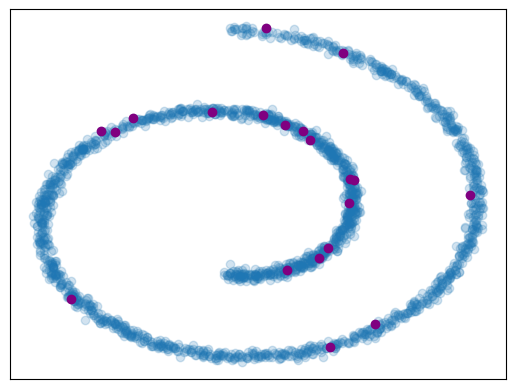

In [3]:
def load_swiss_roll_data(n_samples=400, noise=0.2):
    """
    Generate swiss roll data

    Params:
      - n_samples: number of samples,
      - noise: noise amount,

    Returns:
        torch tensor 2d
    """
    data, _ = make_swiss_roll(n_samples=n_samples, noise=noise)
    data_2d = data[:, [0, 2]]
    data_tensor = torch.tensor(data_2d, dtype=torch.float32)
    data_tensor = (data_tensor - data_tensor.mean(dim=0)) / data_tensor.std(dim=0)
    return data_tensor

class SwissRollDataset(Dataset):
    def __init__(self, n_samples=400, noise=0.2):
        self.data = load_swiss_roll_data(n_samples=n_samples, noise=noise)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]


def plot_data_points(all_data_tensor, draw_samples=None, ax = None):
    """
    Visualizes 2D data points.

    Parameters:
      - all_data_tensor: torch.Tensor of shape [N, 2] containing the main data points.
      - draw_samples: torch.Tensor or None of shape [M, 2] containing additional points to highlight (plotted in green).
    """
    data_np = all_data_tensor.detach().cpu().numpy()

    canvas = ax if ax is not None else plt.gca()

    if draw_samples is not None:
        draw_samples_np = draw_samples.detach().cpu().numpy()
    else:
        draw_samples_np = None

    alpha_value = 0.2 if draw_samples_np is not None else 1.0
    canvas.scatter(data_np[:, 0], data_np[:, 1], alpha=alpha_value)

    if draw_samples_np is not None:
        canvas.scatter(draw_samples_np[:, 0], draw_samples_np[:, 1], c="purple")

    canvas.set_xticks([])
    canvas.set_yticks([])

data = SwissRollDataset(n_samples=2000, noise=0.2)
data_loader = DataLoader(data, batch_size=64, shuffle=True)

plot_data_points(data[:], data[0:20])

# 1. Diffusion Schedule (Расписание шума)

In [4]:
from abc import ABC, abstractmethod
import torch

class BaseDiffusionSchedule(ABC):
    @abstractmethod
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02):
        """
        Abstract base class for diffusion schedules.
        Should be defined by subclasses.:
          - sqrt_alphas_cumprod,
          - sqrt_one_minus_alphas_cumprod.
        """
        pass

    @abstractmethod
    def get_index(self, t):
        """
        Abstract method that returns (sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod) for the time step t.

        Params:
        - t: time step,

        Returns:
            (sqrt alphas cumprod at t, sqrt one minus alphas cumprod at t)
        """
        pass

class LinearDiffusionSchedule(BaseDiffusionSchedule):
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02):
        """
        Linear diffusion schedule.

        Defines:
          - self.sqrt_alphas_cumprod: sqrt(alphas_cumprod)
          - self.sqrt_one_minus_alphas_cumprod: sqrt(1 - alphas_cumprod)
        """
        self.timesteps = timesteps
        betas = torch.linspace(beta_start, beta_end, timesteps)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

    def get_index(self, t):
        """
        Returns (sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod) for the time step t.

        Params:
        - t: time step,
        """

        return self.sqrt_alphas_cumprod[t], self.sqrt_one_minus_alphas_cumprod[t]

In [5]:
noise_scheduler = LinearDiffusionSchedule(100)

first = noise_scheduler.get_index(4)

first

(tensor(0.9987), tensor(0.0501))

In [6]:
def forward_diffusion_sample(x_0, t, device=device):
    """
    Takes the origial state of the vector and add noise to it accordingly to the timestep t.

    Params:
    - x_0: torch tensor 2d
    - t: time step,

    Returns:
        The noisy version of vector at timestep t,
    """
    noise = torch.randn_like(x_0)

    sqrt_alphas_cumprod_t, sqrt_one_minus_alphas_cumprod_t = noise_scheduler.get_index(t - 1)

    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

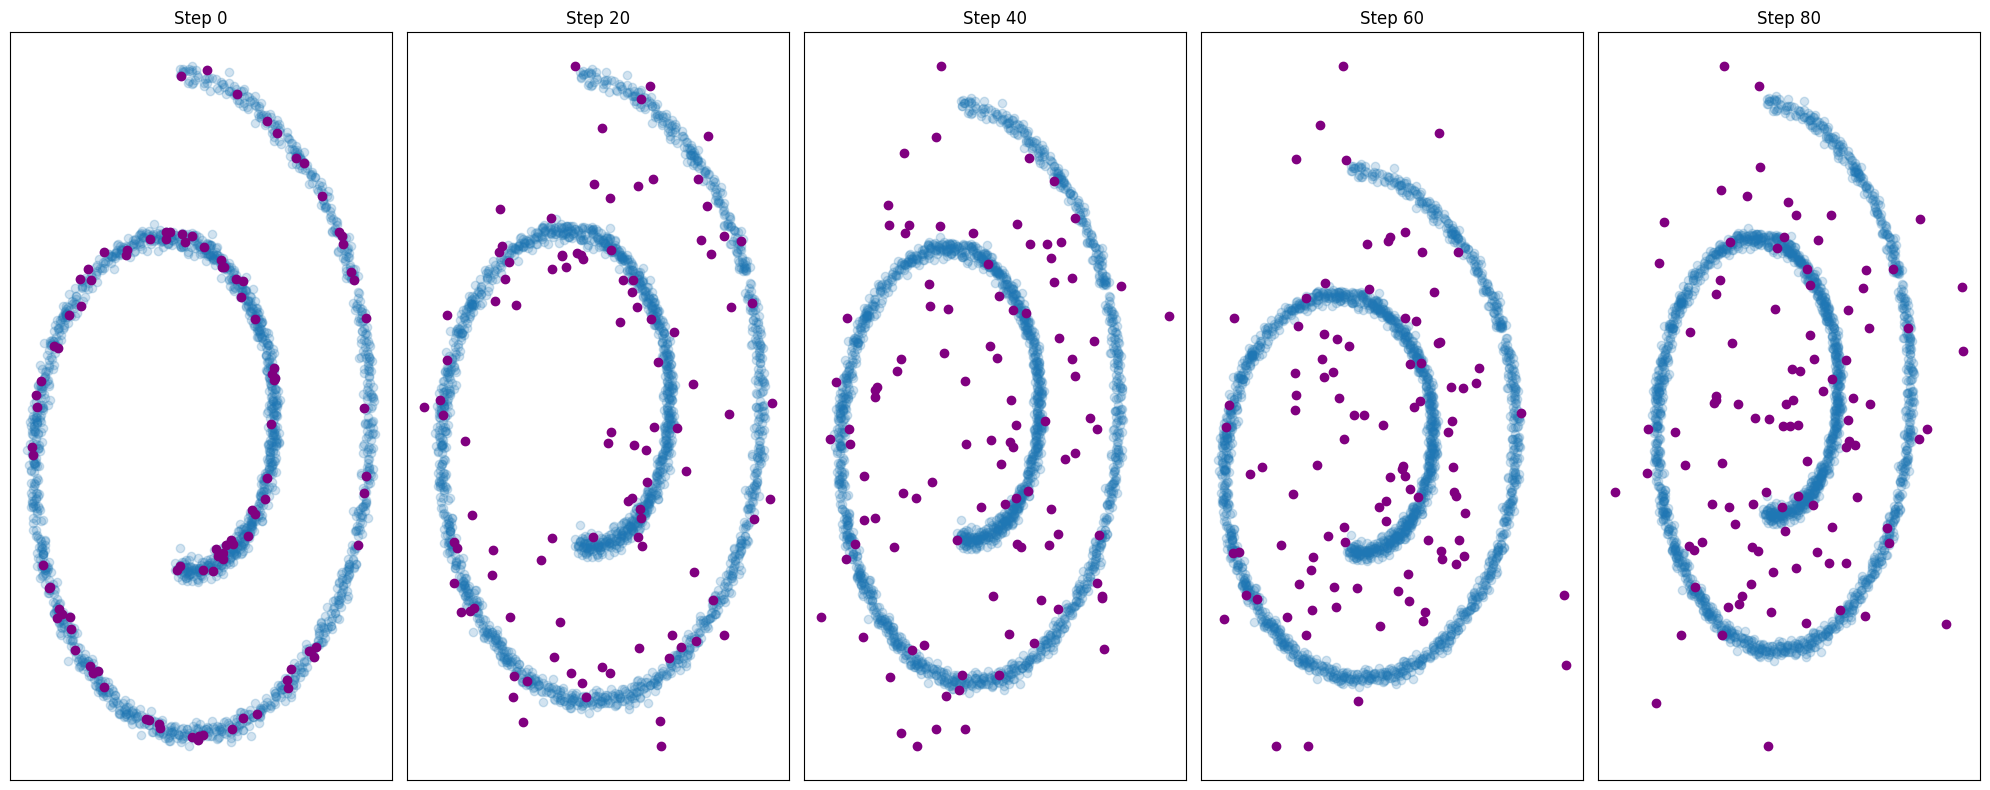

In [7]:
test_vecs = data[0:100]

test_vecs_display = test_vecs.clone()

timesteps = torch.arange(100)

k = 20

fig, axes = plt.subplots(1, len(timesteps) // k, figsize=(20, min(8, 2 * k)))

for i, timestep in enumerate(timesteps):
    if  i % k == 0:
        ax = axes[i // k]
        ax.set_title(f"Step {timestep.item()}")
        plot_data_points(data[:], test_vecs_display, ax)

    test_vecs_display = forward_diffusion_sample(test_vecs, timestep)[0]

plt.tight_layout()
plt.show()


# Basic ANN for noise estimation

In [8]:
import random

class NoiseEstimator(nn.Module):
    def __init__(self, input_dim, timestep_dim):
        """
        Initializes a basic Multi-Layer Perceptron (MLP) model.

        Parameters:
        - input_dim: Dimension of the input features.
        - timestep_dim: Dimension of the hidden layers.
        """
        super(NoiseEstimator, self).__init__()

        self.time_embedding = nn.Sequential(
            nn.Linear(1, timestep_dim),
            nn.ReLU(),
            nn.Linear(timestep_dim, timestep_dim)
        ).to(device)

        self.model = nn.Sequential(
            nn.Linear(input_dim + timestep_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        ).to(device)


    def forward(self, data, timestep):
        time_step = torch.full((data.shape[0], 1), float(timestep), dtype=torch.float, device=data.device)
        t_emb = self.time_embedding(time_step)
        x_input = torch.cat([data, t_emb], dim=1)
        noise_pred = self.model(x_input)
        return noise_pred

# Train

Epoch 0: Loss = 30.4054
Epoch 1: Loss = 29.5262
Epoch 2: Loss = 25.9250
Epoch 3: Loss = 25.7495
Epoch 4: Loss = 27.1180
Epoch 5: Loss = 25.9651
Epoch 6: Loss = 25.4791
Epoch 7: Loss = 24.7780
Epoch 8: Loss = 27.8331
Epoch 9: Loss = 24.6865
Epoch 10: Loss = 24.9450
Epoch 11: Loss = 27.2291
Epoch 12: Loss = 24.8882
Epoch 13: Loss = 24.0752
Epoch 14: Loss = 27.0612
Epoch 15: Loss = 23.8790
Epoch 16: Loss = 24.0432
Epoch 17: Loss = 24.0786
Epoch 18: Loss = 23.4132
Epoch 19: Loss = 23.6500
Epoch 20: Loss = 23.8605
Epoch 21: Loss = 24.1490
Epoch 22: Loss = 24.3086
Epoch 23: Loss = 23.8260
Epoch 24: Loss = 25.3171
Epoch 25: Loss = 23.4355
Epoch 26: Loss = 21.8380
Epoch 27: Loss = 24.1867
Epoch 28: Loss = 23.7249
Epoch 29: Loss = 23.6309
Epoch 30: Loss = 24.5418
Epoch 31: Loss = 24.6661
Epoch 32: Loss = 24.9036
Epoch 33: Loss = 22.9888
Epoch 34: Loss = 25.7483
Epoch 35: Loss = 23.8614
Epoch 36: Loss = 21.3449
Epoch 37: Loss = 21.9091
Epoch 38: Loss = 24.6896
Epoch 39: Loss = 23.7231
Epoch 40: 

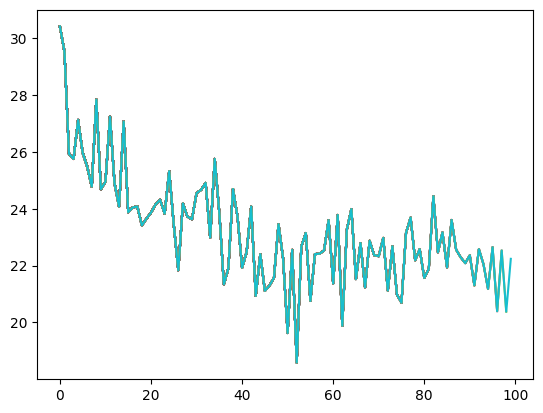

In [11]:
def train(model, data_loader, optimizer, epochs=100):
    """
    Обучает модель на 2D данных (например, Swiss Roll):
      - Перебирает данные батчами,
      - Для каждого батча случайно выбирает t,
      - Вычисляет функцию потерь и обновляет параметры модели.
    """
    model.train()
    epoch_loss = []
    for epoch in range(epochs):

        acc_loss = 0

        for batch_idx, data in enumerate(data_loader):
            data = data.to(device)

            timestep = random.randint(1, noise_scheduler.timesteps)

            noised_vectors, actual_noise = forward_diffusion_sample(data, timestep)

            predicted_noise = model(noised_vectors, timestep)

            loss = F.mse_loss(predicted_noise, actual_noise)

            acc_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}: Loss = {np.mean(acc_loss):.4f}")
        epoch_loss.append(np.mean(acc_loss))

        plt.plot(epoch_loss)


noise_model = NoiseEstimator(input_dim=2, timestep_dim=16)

optimizer_instance = torch.optim.Adam(noise_model.parameters(), lr=0.001)

train_acc = train(noise_model, data_loader, epochs=100, optimizer=optimizer_instance)